# Autoencoders

In [ ]:
!pip uninstall datasets

In [2]:
# !pip install -U datasets
!pip install datasets==2.7.1

  Using cached datasets-2.7.1-py3-none-any.whl (451 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.6
    Uninstalling datasets-2.14.6:
      Successfully uninstalled datasets-2.14.6


In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Data

Now, we switch to the fashion MNIST dataset!

In [4]:
import datasets

In [5]:
from datasets import config
print(config.HF_DATASETS_CACHE)
#Check where the cache directory is located

/home/jamesemi/.cache/huggingface/datasets


In [6]:
!pip install -U datasets 

In [7]:
import os
print(os.getcwd())

/home/jamesemi/git/course22p2/workingnbs/nbs


In [8]:
x,y = 'image','label'
name = "fashion_mnist"
# dsd = load_dataset(name, ignore_verifications=True)
dsd = load_dataset(name, verification_mode='no_checks')

Remember, we created the `@inplace` decorator!

We write a func to transform each image into a tensor:

In [9]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [10]:
bs = 256
tds = dsd.with_transform(transformi)

In [11]:
tds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

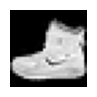

In [12]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1,1));

Now we collate the dictionarties using the function we've built already.

In [13]:
cf = collate_dict(ds)

In [25]:
def collate_(b): return to_device(cf(b))
def data_loaders(dsd, bs, **kwargs): return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}

An improved `data_loaders()` function:

In [15]:
# def collate_(b): return to_device(cf(b))
# def data_loaders(dsd, bs, **kwargs): return {k:DataLoader(v, bs, num_workers = 8, **kwargs) for k,v in dsd.items()}

In [26]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [27]:
dt = dls['train']
dv = dls['test']

xb,yb = next(iter(dt))

In [28]:
dt = dls['train']
dv = dls['test']

xb,yb = next(iter(dt))

Using the improved dataloaders with `def data_loaders(dsd, bs, **kwargs): return {k:DataLoader(v, bs, num_workers = 8, **kwargs) for k,v in dsd.items()}`, we get an error. In PyTorch, using multiple processes can start to get complicated. What you definitely can't have your dataloader put things onto the GPU into separate processes. The reason for the error is that we used a collate function to put tings on the function - that is incompatible with using multiple workers. The answer to that problem is that we have to rewrite the fit function entirely. We don't want that. Problem #2? The accuracy we get (86.68%) is not good.

Pull the labels:

In [29]:
labels = ds.features[y].names

In [30]:
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [31]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels) #get the titles of everything in the minibatch

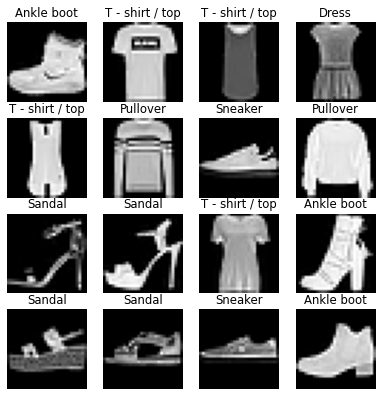

In [32]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

There we have it, the Fashion-MNIST minibatch!

## Warmup - classify

In [ ]:
from torch import optim

bs = 256
lr = 0.4

Just using the model from the `07_convolutions.ipynb` notebook:

In [ ]:
cnn = nn.Sequential(
    conv(1, 4),      #14x14
    conv(4, 8),      #7x7
    conv(8, 16),     #4x4
    conv(16, 16),    #2x2
    conv(16,10, act=False),
    nn.Flatten()).to(def_device)

In [ ]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss,acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

You can see here that the model is training VERY slowly. Let's analyze the problem:

In [ ]:
dsd['train'][0]

With this, we start to see the problem. In MNIST, we had all the data loaded into a single big tensor. But, this HF one is created in a more normal way - where each image is a singlt .png file - without being pre-converted. Why is that a problem? Because - out dataloader is spending all of its time decoding these .png files.

Run `htop` hen training your model, and you see the CPU usage:  
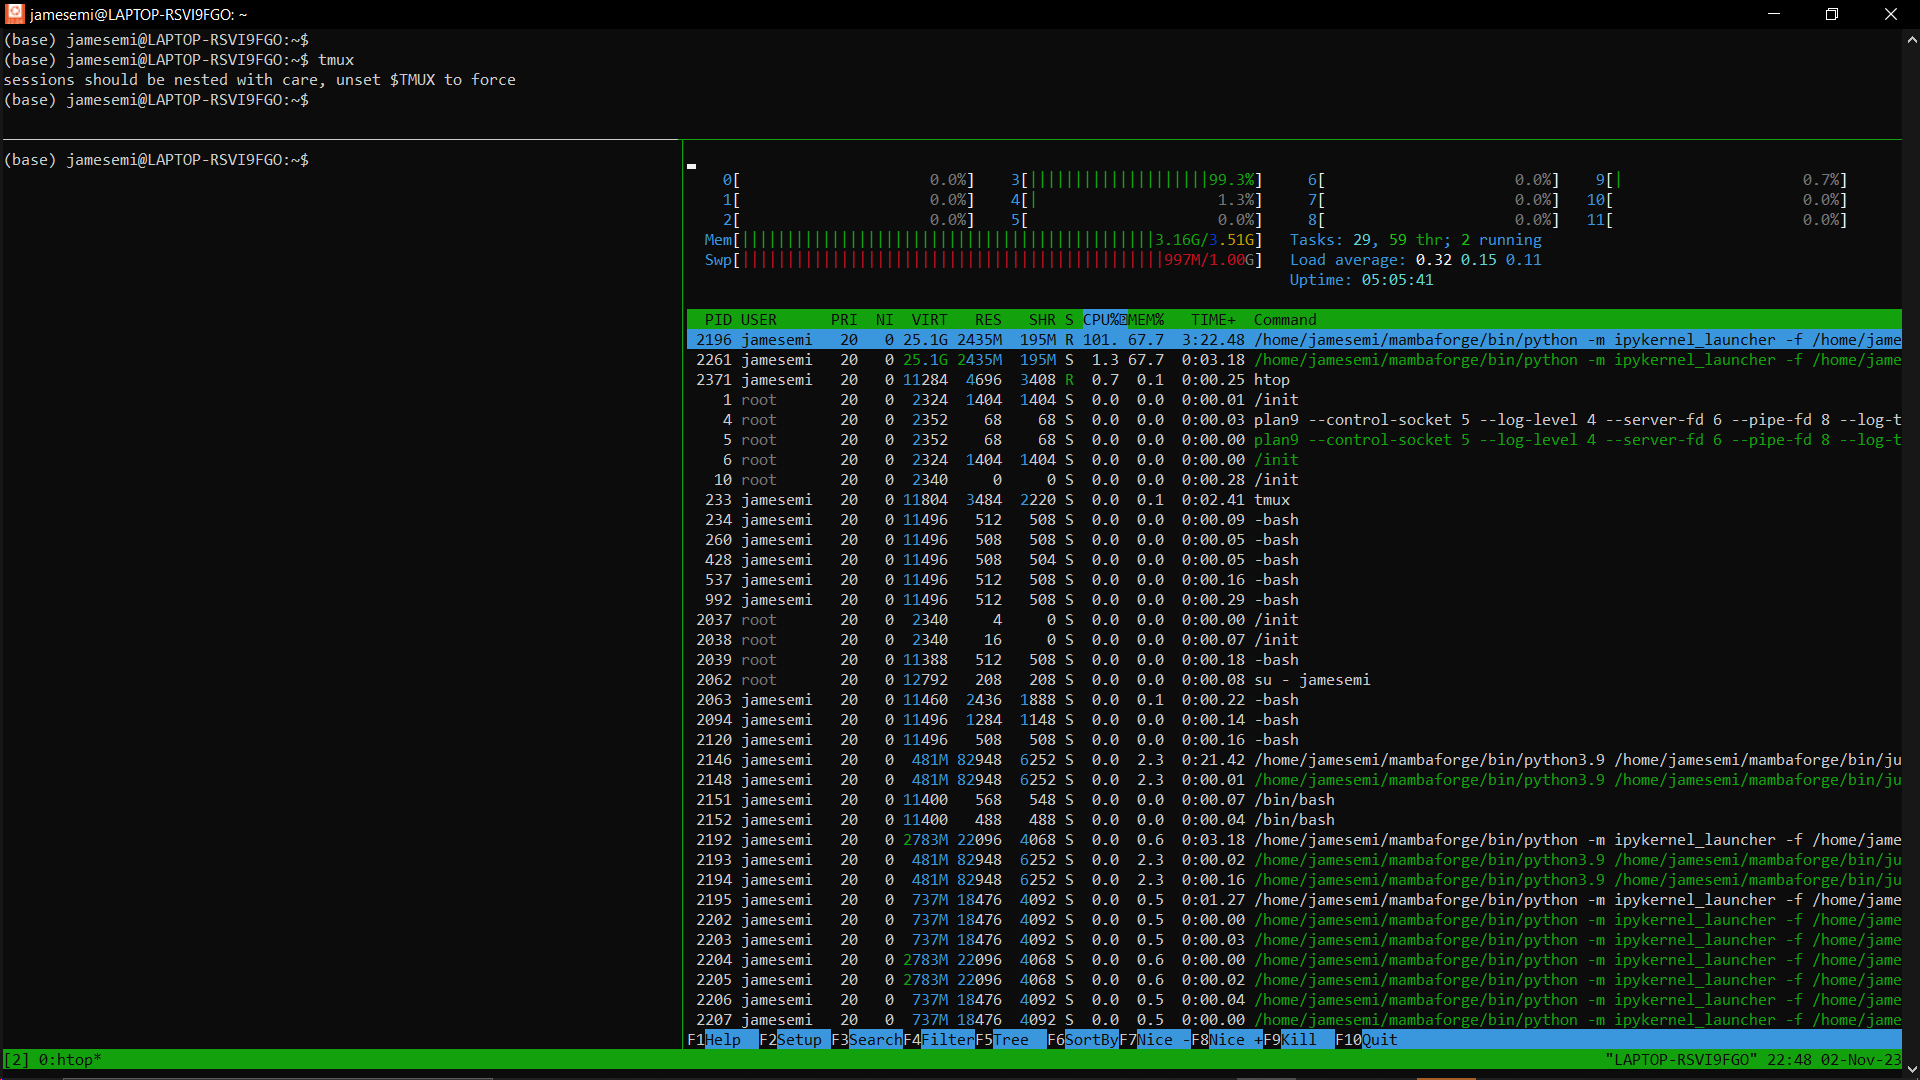

It's weird that only one CPU is being used - and also, that it is being used to a 100%.

Now, why does that matter? Run `nvidia-smi dmon -i 0`:  
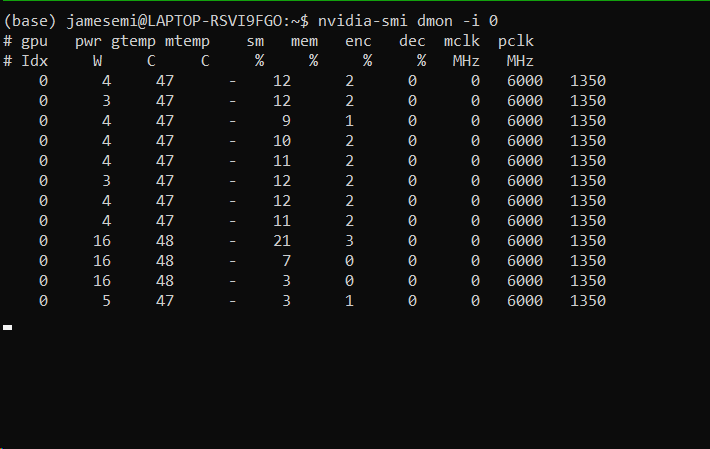  
Look at `sm` - symmetric multiprocessor. See how we're only using close to 10% of the GPU? Figure out how to use more GPU compute.

Also, 86% is really not accurate. How do we know? Go to paperswithcode fashion mnist leaderboard:  
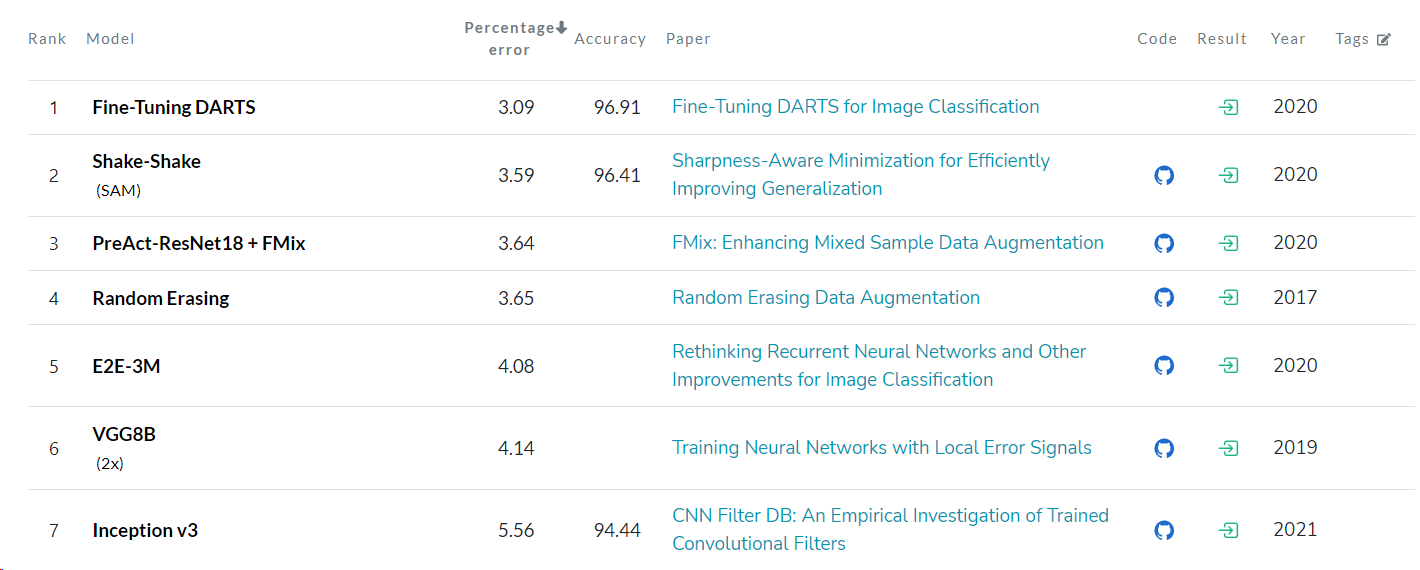  
We're not doing too great with the simple CNN. How do we improve that? We could try a bunch of things - but all of them are going to involve modifying the `fit()` function in complicated ways. Let's put that aside and get on with creating an autoencoder.

## Autoencoder

In [33]:
def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

`padding=ks//2` is a truncating division that works for any odd sized kernel.

We've pulled out `eval()` into a separate function:

In [34]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred,xb).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

Should come back and understand every single line of this!!

In [35]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)

Notice here that `loss_func` is being applied to `xb` and the output of the model.

In [36]:
ae = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
    conv(2,4),        #8x8
#     conv(4,8),        #4x4
#     deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(def_device)

In [37]:
eval(ae, F.mse_loss, dv)

0 0.168


In [38]:
opt = optim.SGD(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.127
1 0.119
2 0.111
3 0.100
4 0.083


In [39]:
opt = optim.SGD(ae.parameters(), lr=0.1)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.033
1 0.029
2 0.026
3 0.025
4 0.023


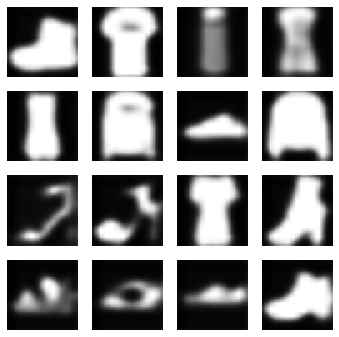

In [40]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

In [ ]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

In [ ]:
show_images(xb[:16].data.cpu(), imsize=1.5)

But we cannot be working like this - we want to have code setup such that we can iterate fast. For that, we createa learner.